In [14]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
import os

import tensorly as tl
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac, non_negative_parafac

import Ipynb_importer
#from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor2, Energy_Loss_Tensor, Recon_Loss, Recon_Loss_Straight, Recon_Loss_NMF, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm
from NNCPD import NNCPD, weights_H, Energy_Loss_Tensor, Recon_Loss, Recon_Loss_Straight, Recon_Loss_NMF, L21_Norm, outer_product, outer_product_np, PTF, random_NNCPD, Fro_Norm

from lsqnonneg_module import LsqNonneg
from trainNNCPD import train

import torch.nn as nn
from torch.autograd import Variable
from writer import Writer

torch.set_default_tensor_type(torch.DoubleTensor)

In [15]:
w = 320
h = 180
#w=640
#h=360

## Generate Frames from Video

In [18]:
if(True):
    count = 0
    videoFile = "../Videos/nature_video.mp4"
    cap = cv2.VideoCapture(videoFile)   # capturing the video from the given path
    frameRate = cap.get(5) #frame rate
    #print(frameRate)
    #rameRate = 5
    x=1
    
    try:
        os.mkdir("Images")
    except OSError:
        pass
    
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        frame = cv2.resize(frame, (w,h))
        if (frameId % math.floor(frameRate) == 0):
            filename ="Images/frame%d.jpg" % count;count+=1
            cv2.imwrite(filename, frame)
    cap.release()

Done!


In [29]:
n = 37
X = np.zeros((n,h,w,3))

for i in range(n):
    im = plt.imread('Images/frame' + str(i) + '.jpg')
    X[i,:,:,:] = im

In [30]:
X = X.reshape((n, -1,3)).transpose((0,2,1))

### Visualize first 36 Frames

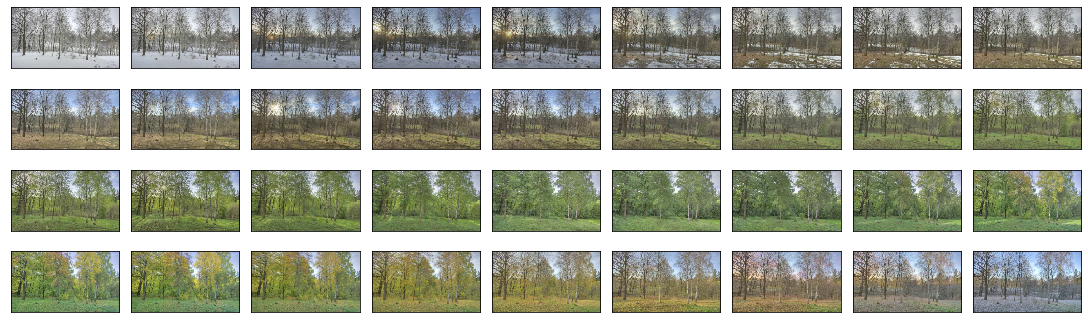

In [31]:
X_int = X.astype(int)
fig, axs = plt.subplots(4, 9, constrained_layout=True, figsize=(15,4.5))

for i in range(36):
    x = int(i/9)
    y = i%9
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])
    axs[x,y].imshow(X_int[i].reshape((3,h,w)).transpose((1,2,0)))

### Visualize a Samples of Frames, as in Paper

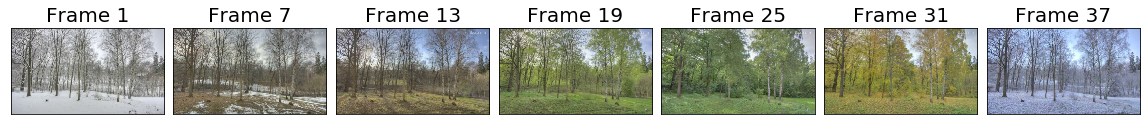

In [33]:
X_int = X.astype(int)
fig, axs = plt.subplots(1, 7, constrained_layout=False, figsize=(16,4.2))

for x, i in enumerate([1,7,13,19,25,31,37]):  
    i = i - 1
    axs[x].axes.xaxis.set_ticks([])
    axs[x].axes.yaxis.set_ticks([])
    axs[x].set_title("Frame " + str(i+1), fontsize=20)
    axs[x].imshow(X_int[i].reshape((3,h,w)).transpose((1,2,0)))
  
plt.subplots_adjust(left=0.125, bottom=0.1, right=2.769, top=0.9, wspace=0.001, hspace=0.035)
fig.tight_layout()
plt.show()

In [ ]:
X = torch.from_numpy(X)

r=8
n1,n2,n3 = X.shape
net = NNCPD([n1,6,3],[n2,6,3],[n3,6,3])

loss_func = Energy_Loss_Tensor()

history_unsupervised = train(net, X, loss_func, r, epoch = 1400, lr1 = 0, lr2 = 0.04, verbose_epoch=200)

In [ ]:
history_unsupervised.plot_scalar('loss')

In [ ]:
#np.save("history_video_rank8_6_3_800_iters", history_unsupervised.tensor_dict)
X_1 = history_unsupervised.get('A_X1')[-1]
X_2 = history_unsupervised.get('B_X1')[-1]
X_3 = history_unsupervised.get('C_X1')[-1]

A_A1 = history_unsupervised.get('A_A1')[-1]
A_S1 = history_unsupervised.get('A_S1')[-1]
B_A1 = history_unsupervised.get('B_A1')[-1]
B_S1 = history_unsupervised.get('B_S1')[-1]
C_A1 = history_unsupervised.get('C_A1')[-1]
C_S1 = history_unsupervised.get('C_S1')[-1]

A_A2 = history_unsupervised.get('A_A2')[-1]
A_S2 = history_unsupervised.get('A_S2')[-1]
B_A2 = history_unsupervised.get('B_A2')[-1]
B_S2 = history_unsupervised.get('B_S2')[-1]
C_A2 = history_unsupervised.get('C_A2')[-1]
C_S2 = history_unsupervised.get('C_S2')[-1]

In [ ]:
fig, axs = plt.subplots(4, 2, constrained_layout=True, figsize=(11,12))
for i in range(8):
    x = int(i/2)
    y = i%2
    axs[x][y].imshow(X_3[:,i].reshape(h,w)*70)
    axs[x][y].set_title("Topic #" + str(i+1))
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])

In [ ]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(11,7))
color = "viridis"

plt.sca(axs[1])
plt.xticks(range(8), range(1,9))
plt.yticks(range(3), ['Red', 'Green', 'Blue'])

axs[0].imshow(X_1, cmap=plt.get_cmap(color))
axs[1].imshow(X_2, cmap=plt.get_cmap(color))
axs[2].imshow(X_1 @ X_2.T, cmap=plt.get_cmap(color))


In [ ]:
fig, axs = plt.subplots(3, 2, constrained_layout=True, figsize=(11,10))
for i in range(6):
    x = int(i/2)
    y = i%2
    axs[x][y].imshow(C_A1[:,i].reshape(h,w)*70)
    axs[x][y].set_title("Topic #" + str(i+1))
    #plt.sca(axs[x][y])
    axs[x][y].axes.xaxis.set_ticks([])
    axs[x][y].axes.yaxis.set_ticks([])
    #plt.xticks(range(10), ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'])

In [ ]:
if(False):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,7))
    color = "viridis"

    plt.sca(axs[1])
    plt.xticks(range(6), range(1,7))
    plt.yticks(range(3), ['Red', 'Green', 'Blue'])
    axs[0].imshow(A_A1, cmap=plt.get_cmap(color))
    axs[1].imshow(B_A1, cmap=plt.get_cmap(color))

In [ ]:
weight = weights_H(A_A1, B_A1, C_A1, A_S1, B_S1, C_S1)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(9,7))
color = "viridis"

A_A1_new = A_A1 @ weight[:,:,0].T 
B_A1_new = B_A1 @ weight[:,:,1].T
print(B_A1_new)
#print((w[:,:,1] / np.sum(w[:,:,1])))

plt.sca(axs[1])
plt.xticks(range(6), range(1,7))
plt.yticks(range(3), ['Red', 'Green', 'Blue'])

axs[0].imshow(A_A1_new, cmap=plt.get_cmap(color))
axs[1].imshow(B_A1_new, cmap=plt.get_cmap(color))
axs[2].imshow(A_A1_new @ B_A1_new.T, cmap=plt.get_cmap(color))
plt.show()

In [ ]:
weight = weights_H_sqrt(A_A1, B_A1, C_A1, A_S1, B_S1, C_S1)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(9,7))
color = "viridis"

A_A1_new = A_A1 @ weight[:,:,0].T 
B_A1_new = B_A1 @ weight[:,:,1].T
print(B_A1_new)
#print((w[:,:,1] / np.sum(w[:,:,1])))

plt.sca(axs[1])
plt.xticks(range(6), range(1,7))
plt.yticks(range(3), ['Red', 'Green', 'Blue'])

axs[0].imshow(A_A1_new, cmap=plt.get_cmap(color))
axs[1].imshow(B_A1_new, cmap=plt.get_cmap(color))
axs[2].imshow(A_A1_new @ B_A1_new.T, cmap=plt.get_cmap(color))
plt.show()

In [ ]:
C2 = torch.mm(C_A1, C_A2)
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(7,12))
for i in range(3):
    axs[i].axes.xaxis.set_ticks([])
    axs[i].axes.yaxis.set_ticks([])
    axs[i].imshow(C2[:,i].reshape(h,w)*70)

In [ ]:
if(False):
    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize=(12,5))
    color = "viridis"

    A2 = torch.mm(A_A1,A_A2)
    B2 = torch.mm(B_A1,B_A2)
    axs[0].imshow(A2, cmap=plt.get_cmap(color))
    axs[1].imshow(B2, cmap=plt.get_cmap(color))

In [ ]:
weight = weights_H(A2, B2, C2, A_S2, B_S2, C_S2)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(8,6))
color = "viridis"

#A2_new = A2 @ np.sqrt(weight[:,:,0].T)
#B2_new = B2 @ np.sqrt(weight[:,:,1].T)
A2_new = A2 @ weight[:,:,0].T
B2_new = B2 @ weight[:,:,1].T
print(B2_new)
#print((w[:,:,1] / np.sum(w[:,:,1])))

plt.sca(axs[1])
plt.xticks(range(3), range(1,4))
plt.yticks(range(3), ['Red', 'Green', 'Blue'])

axs[0].imshow(A2_new, cmap=plt.get_cmap(color))
axs[1].imshow(B2_new, cmap=plt.get_cmap(color))
axs[2].imshow(A2_new @ B2_new.T, cmap=plt.get_cmap(color))
plt.show()

In [ ]:
weight = weights_H_sqrt(A2, B2, C2, A_S2, B_S2, C_S2)

fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(8,6))
color = "viridis"

#A2_new = A2 @ np.sqrt(weight[:,:,0].T)
#B2_new = B2 @ np.sqrt(weight[:,:,1].T)
A2_new = A2 @ weight[:,:,0].T
B2_new = B2 @ weight[:,:,1].T
print(B2_new)
#print((w[:,:,1] / np.sum(w[:,:,1])))

plt.sca(axs[1])
plt.xticks(range(3), range(1,4))
plt.yticks(range(3), ['Red', 'Green', 'Blue'])

axs[0].imshow(A2_new, cmap=plt.get_cmap(color))
axs[1].imshow(B2_new, cmap=plt.get_cmap(color))
axs[2].imshow(A2_new @ B2_new.T, cmap=plt.get_cmap(color))
plt.show()

In [ ]:
approx_w = outer_product(A_A1_new, B_A1_new, C_A1)
approx_2 = outer_product(A_A1, B_A1, C_A1)
approx = outer_product(X_1, X_2, X_3)
print(torch.norm(X))
print(torch.norm(approx-X))
print(torch.norm(approx_w-X))
print(torch.norm(approx_2-X))

In [ ]:
X_approx = outer_product(torch.mm(A_A1,A_S1), torch.mm(B_A1,B_S1), torch.mm(C_A1,C_S1)).numpy().astype(int)
print(np.max(X_approx[1]))
fig, axs = plt.subplots(6, 6, constrained_layout=True, figsize=(14,14))
for i in range(36):
    temp = X_approx[i].reshape((3,h,w)).transpose((1,2,0))
    axs[int(i/6),i%6].imshow(temp)

In [ ]:
def weights_H_sqrt(A, B, C, H_A, H_B, H_C):
    
    alphas = []
    n_1, r = A.shape
    n_2, r = B.shape
    n_3, r = C.shape
    weights = torch.zeros((r, r, 2))
    
    
    for col in range(r):
        for it in range(r**2):
            i = int(it % r)
            j = int((it/r) % r)

            weights[col, i, 0] += torch.sqrt(torch.sum(H_A[i] * H_B[j] * H_C[col]))
            weights[col, j, 1] += torch.sqrt(torch.sum(H_A[i] * H_B[j] * H_C[col]))
            #weights[col, i, 0] += torch.sum(H_A[i] * H_B[j] * H_C[col])
            #weights[col, j, 1] += torch.sum(H_A[i] * H_B[j] * H_C[col])
         


    return weights

In [ ]:
def intro_product(A, B, C, H_A, H_B, H_C, get_alpha=False):
    
    alphas = []
    n_1, r = A.shape
    n_2, r = B.shape
    n_3, r = C.shape
    X_approx = torch.zeros((n_1,n_2,n_3))
    
    
    for it in range(r**3):
        i = int(it % r)
        j = int((it/r) % r)
        k = int((it/(r**2) % r))
        
        alpha = torch.sum(H_A[i] * H_B[j] * H_C[k]);
        alphas.append(alpha)
        X_approx += alpha * torch.einsum('p, qr->pqr',A[:,i],torch.ger(B[:,j],C[:,k]))
         
    if get_alpha:
        return X_approx, alphas
    else:
         return X_approx

In [ ]:
A = A_A1
B = B_A1
C = C_A1
_, alphas = intro_product(A_A1, B_A1, C_A1, A_S1, B_S1, C_S1)
true_outer = outer_product(A,B,C)

n_1, r = A.shape
n_2, r = B.shape
n_3, r = C.shape
X_approx = torch.zeros((n_1,n_2,n_3))

X_approx += A_S1[1] 

In [ ]:
A = torch.rand((10,4))
B = torch.rand((10,4))
C = torch.rand((10,4))

H1 = torch.rand((4,8))
H2 = torch.rand((4,8))
H3 = torch.rand((4,8))

In [ ]:
test = intro_product(A,B,C,H1,H2,H3).numpy().reshape((-1,10))

In [ ]:
np.linalg.matrix_rank(test)

In [ ]:
A = torch.rand((3,2))
B = torch.rand((3,2))
C = torch.rand((3,2))

r = 2
X_approx = torch.zeros((3,3,3))


for it in range(r**3):
    i = int(it % r)
    j = int((it/r) % r)
    k = int((it/(r**2) % r))

    alpha = np.random.rand()#torch.sum(H_A[i] * H_B[j] * H_C[k]);
    X_approx += alpha * torch.einsum('p, qr->pqr',A[:,i],torch.ger(B[:,j],C[:,k]))


In [ ]:
test = X_approx.numpy().reshape((-1,3))

In [ ]:
np.linalg.matrix_rank(test)

In [ ]:
print(test)

In [ ]:
from sklearn.decomposition import SparseCoder

In [ ]:
s = SparseCoder(test[:,[0,1]].T, transform_algorithm='lasso_lars', transform_alpha=0, positive_code=True)

In [ ]:
c = s.transform(test[:,[2]].T)

In [ ]:
c

In [ ]:
np.dot(test[:,[0,1]], c.T).T

In [ ]:
test[:,[0,1]]

In [ ]:
0.33357647 * 0.79 + 0.32527775 * 0.41

In [ ]:
0.24165182 * 0.79 + 0.22585734 * 0.41

In [ ]:
0.33357647/0.24165182

In [ ]:
0.32527775/0.22585734

In [ ]:
0.39822979/0.28013009

In [ ]:
"""
n_2, r = B.shape
n_3, r = C.shape
X_approx = torch.zeros((n_1,n_2,n_3))


for it in range(r**2):
    i = int(it % r)
    j = int((it/r) % r)

    x = torch.rand((n_1))#torch.sum(H_A[i] * H_B[j] * H_C[k]);
    X_approx += torch.einsum('p, qr->pqr',x,torch.ger(B[:,i],C[:,j]))
"""

In [ ]:
test = X_approx.numpy().reshape((-1,10))
np.linalg.matrix_rank(test)